In [1]:
import dill

In [2]:
from importlib.resources import files

In [3]:
from optiwindnet.interarraylib import G_from_S
from optiwindnet.svg import svgplot
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.baselines.hgs import hgs_multiroot
from optiwindnet.importer import L_from_yaml
from optiwindnet.pathfinding import PathFinder
from optiwindnet.MILP import solver_factory, ModelOptions
from optiwindnet.interarraylib import as_normalized

## Reference solution

Yi, X., Scutariu, M., & Smith, K. (2019). Optimisation of offshore wind farm inter-array collection system. IET Renewable Power Generation, 13(11), 1990–1999. https://doi.org/10.1049/iet-rpg.2018.5805

The network was not parsed from the paper, using the published total cable lengths:
- radial: 162.3 km
- branched: 154.6 km

In [4]:
λ_radial = 162300
λ_branched = 154600

## Start here

In [5]:
solver = solver_factory('gurobi')

In [6]:
base_dir = files('optiwindnet.data')
inputfile = base_dir / 'Yi-2019.yaml'
L = L_from_yaml(inputfile)

In [7]:
P, A = make_planar_embedding(L)
A_norm = as_normalized(A)

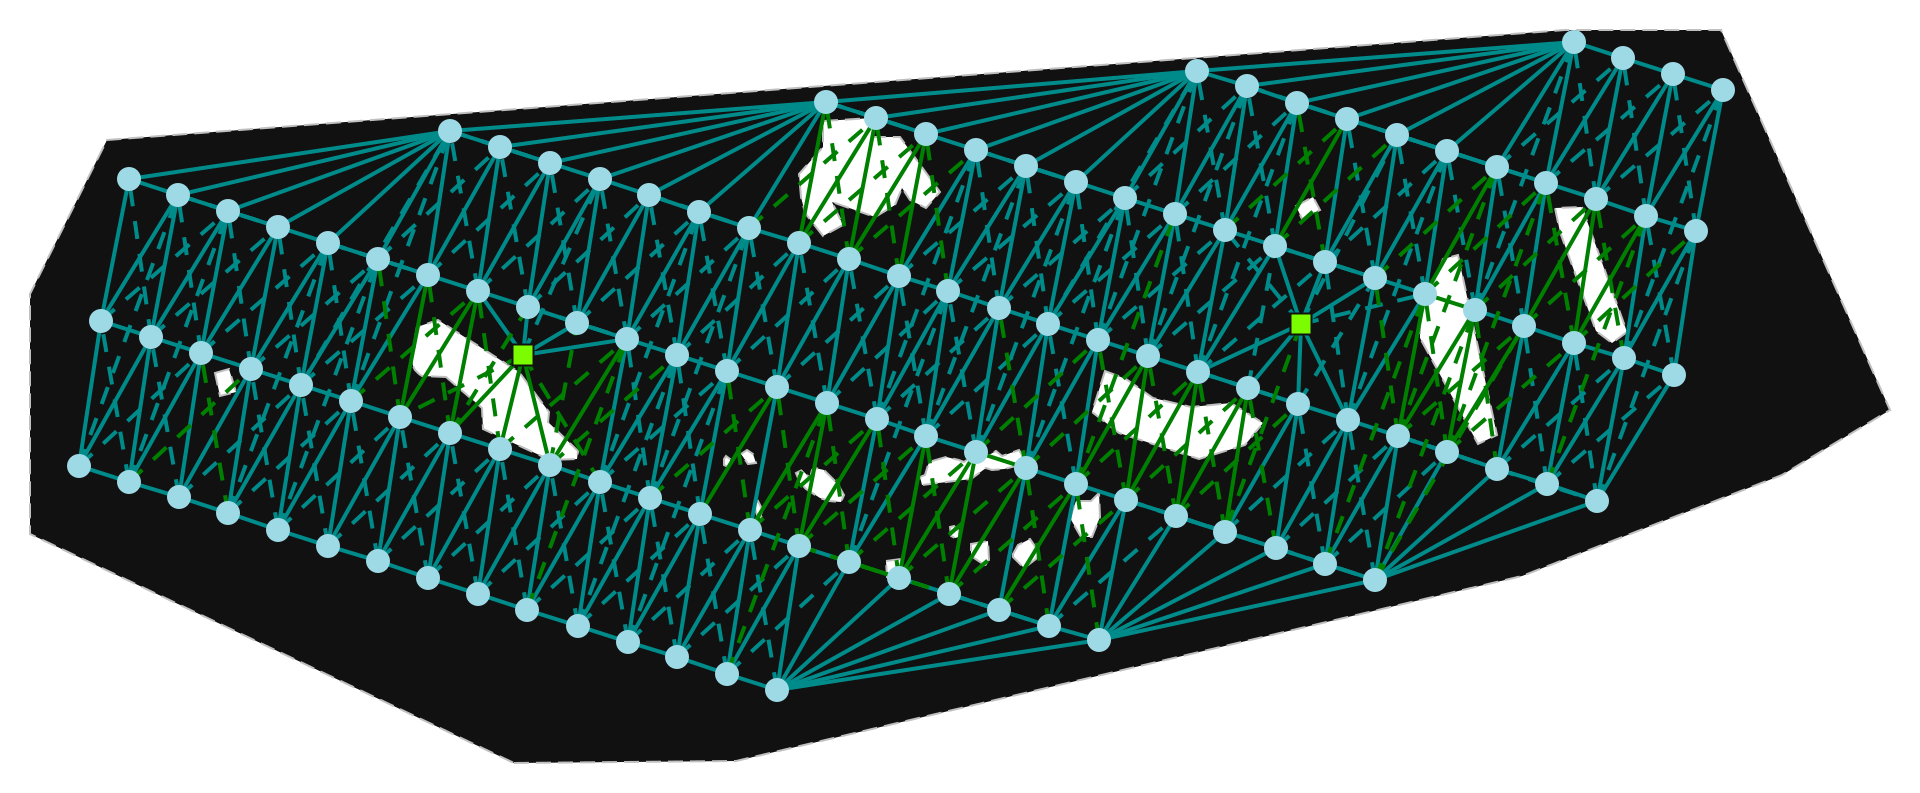

In [8]:
svgplot(A)

## Solve κ = 6 (branched)

In [9]:
Sʹ = hgs_multiroot(A_norm, capacity=6, time_limit=0.5)

In [10]:
Sʹ.graph['solution_time']

(0.4, 0.19)

In [11]:
Gʹ = G_from_S(Sʹ, A)

In [12]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

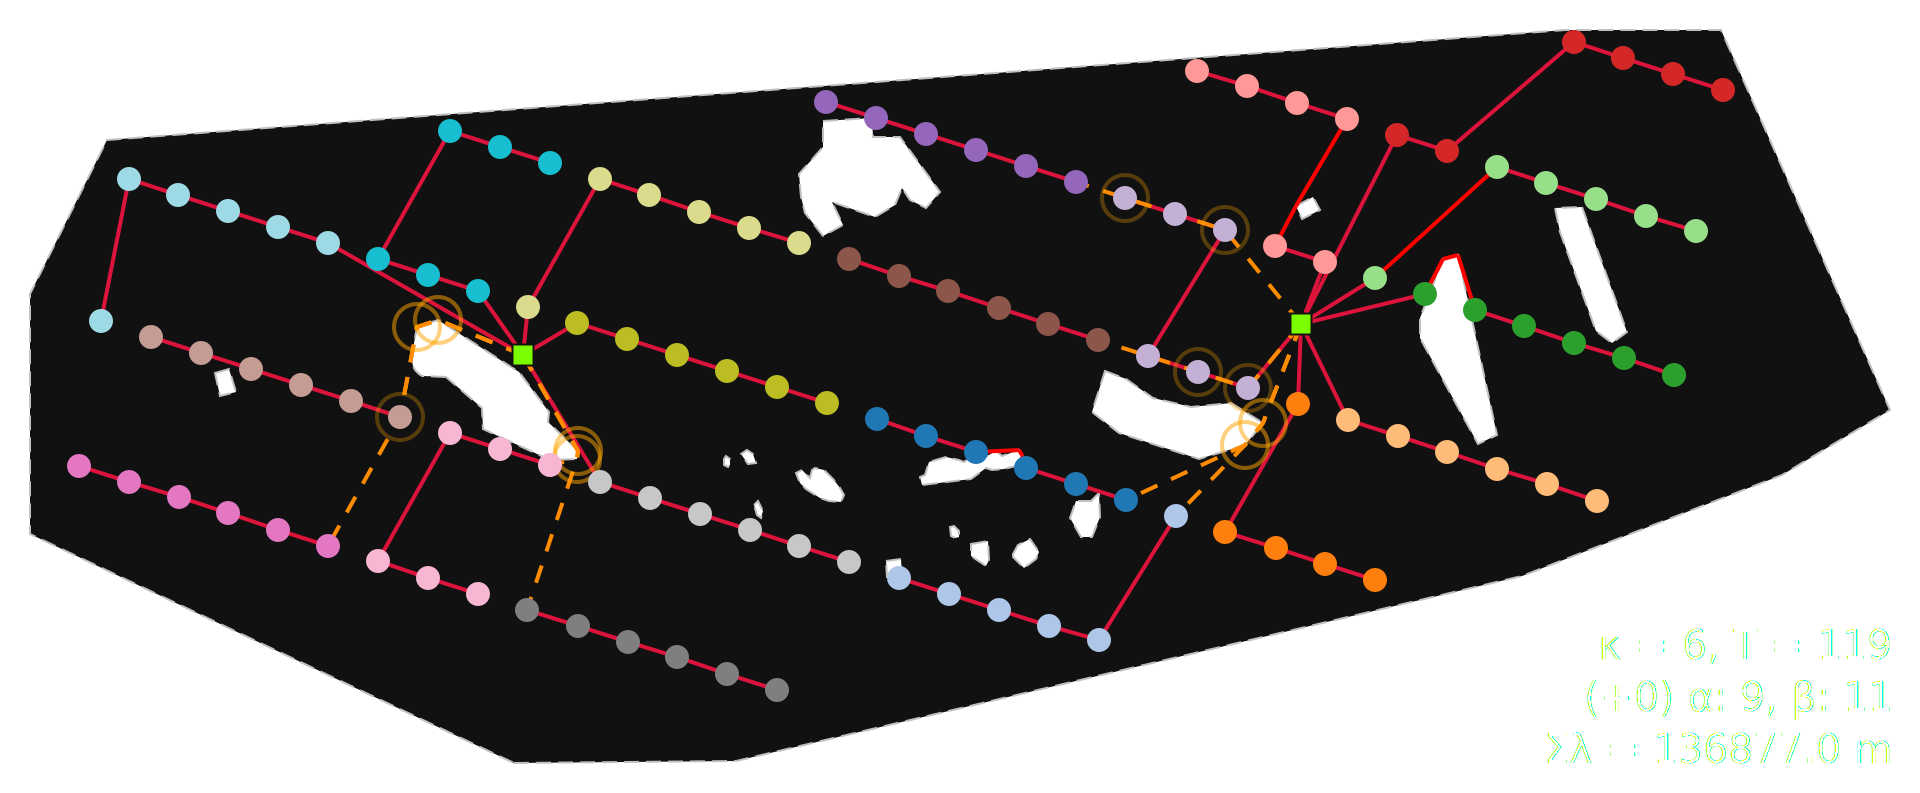

In [13]:
svgplot(Hʹ)

In [14]:
1 - Hʹ.size(weight='length')/λ_branched

0.11463530574482794

In [15]:
solver.set_problem(
    P, A_norm,
    capacity=Sʹ.graph['capacity'],
    model_options=ModelOptions(
        topology="branched",
        feeder_route="segmented",
        feeder_limit="minimum",
    ),
    warmstart=Sʹ,
)

In [16]:
solver.solve(
    mip_gap=0.005,
    time_limit=45,
    verbose=True,
    options=dict(mipfocus=1),
)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  45
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 3852 rows, 2592 columns and 14542 nonzeros
Model fingerprint: 0xcba7b093
Variable types: 0 continuous, 2592 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 10.7844

Presolve removed 414 rows and 0 columns
Presolve time: 0.02s
Presolved: 3438 rows, 2592 columns, 13240 nonzeros
Variable types: 0 continuous, 2592 integer (1296 binary)

Root relaxation: objective 

SolutionInfo(runtime=45.0789999961853, bound=10.398024852271213, objective=10.588209958443283, relgap=0.017961969673675804, termination='maxTimeLimit')

In [17]:
S, G = solver.get_solution(A)

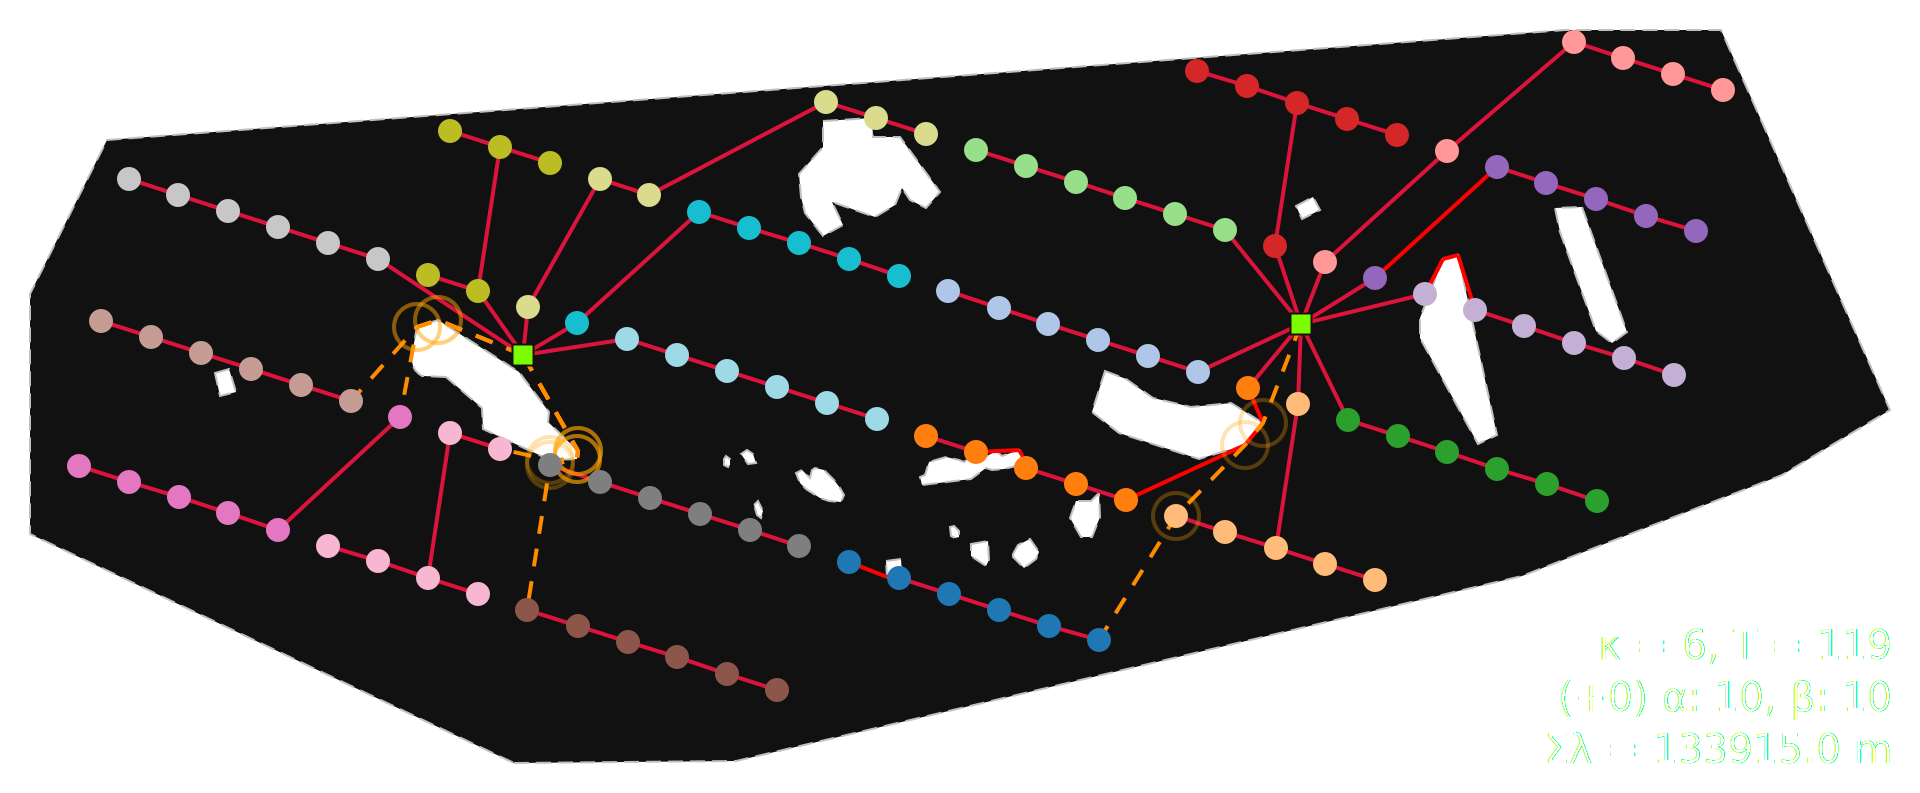

In [18]:
svgplot(G)

In [19]:
1 - G.size(weight='length')/λ_branched

0.13379531445617387

In [20]:
with open('yi_2019_κ_6_branched_our.dill', 'wb') as outfile:
    dill.dump(G, outfile)

## Solve κ = 6 (radial)

In [21]:
Sʹ = hgs_multiroot(A_norm, capacity=6, time_limit=0.5)

In [22]:
Sʹ.graph['solution_time']

(0.43, 0.19)

In [23]:
Gʹ = G_from_S(Sʹ, A)

In [24]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

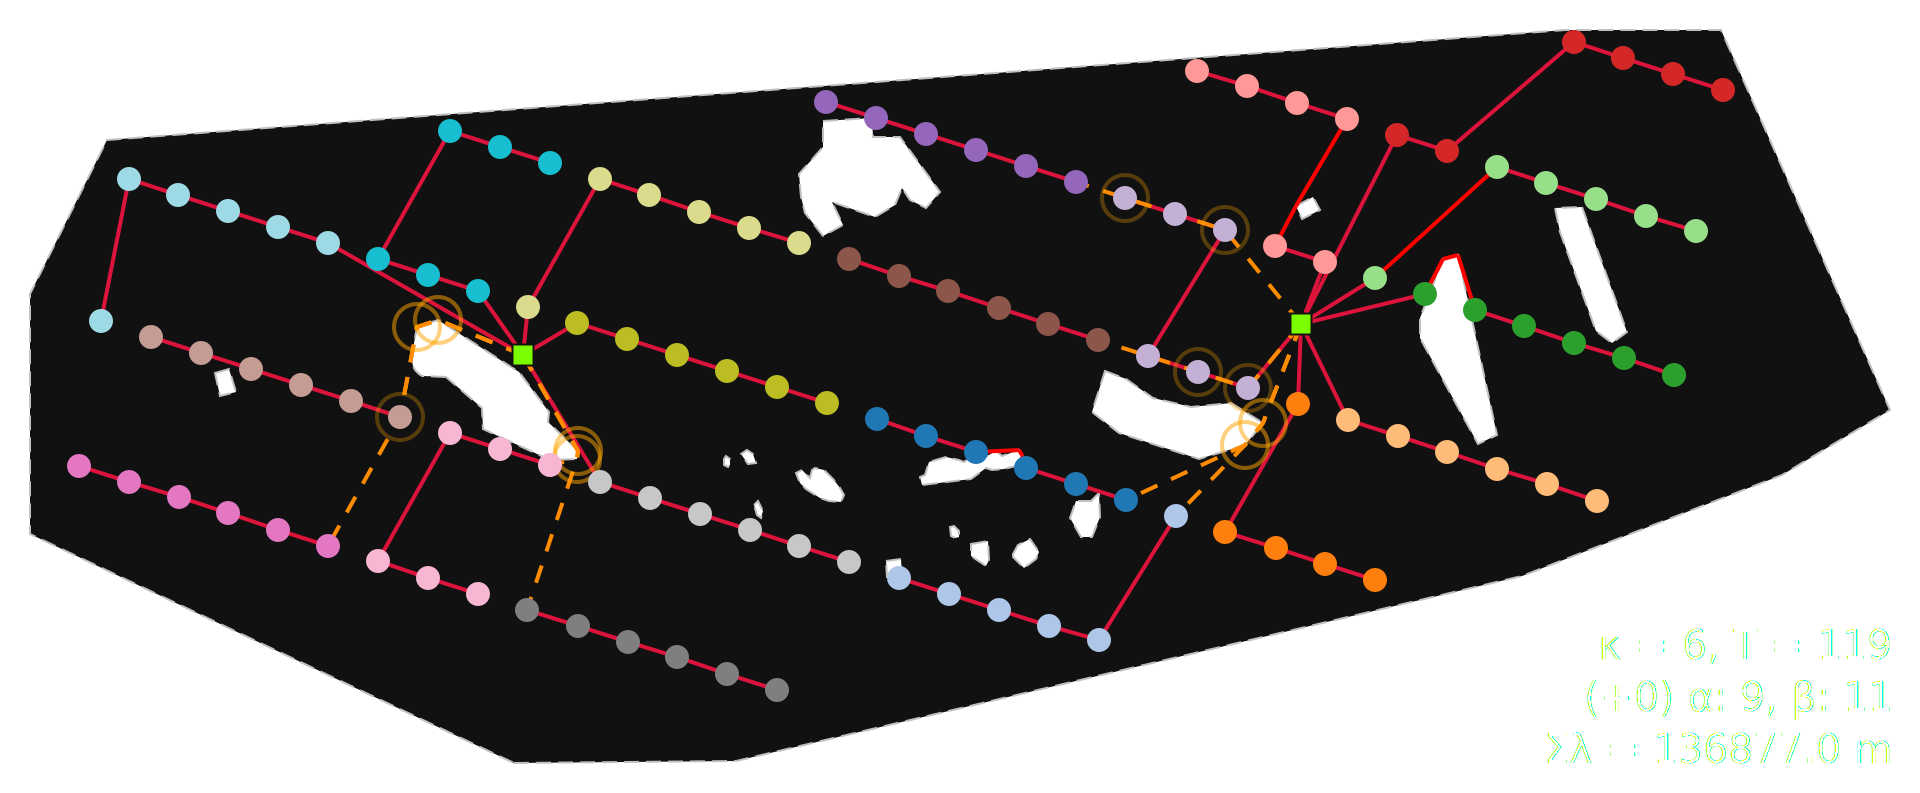

In [25]:
svgplot(Hʹ)

In [26]:
1 - Hʹ.size(weight='length')/λ_radial

0.15663966893499937

In [27]:
solver.set_problem(
    P, A_norm,
    capacity=Sʹ.graph['capacity'],
    model_options=ModelOptions(
        topology="radial",
        feeder_route="segmented",
        feeder_limit="minimum",
    ),
    warmstart=Sʹ,
)

In [28]:
solver.solve(
    mip_gap=0.005,
    time_limit=45,
    verbose=True,
    options=dict(mipfocus=1),
)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  45
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 3971 rows, 2592 columns and 15600 nonzeros
Model fingerprint: 0x66fae53e
Variable types: 0 continuous, 2592 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 10.7844

Presolve removed 414 rows and 0 columns
Presolve time: 0.03s
Presolved: 3557 rows, 2592 columns, 14298 nonzeros
Variable types: 0 continuous, 2592 integer (1296 binary)

Root relaxation: objective 

SolutionInfo(runtime=45.09099984169006, bound=10.466387656186585, objective=10.61605486611012, relgap=0.014098194838962352, termination='maxTimeLimit')

In [29]:
S, G = solver.get_solution(A)

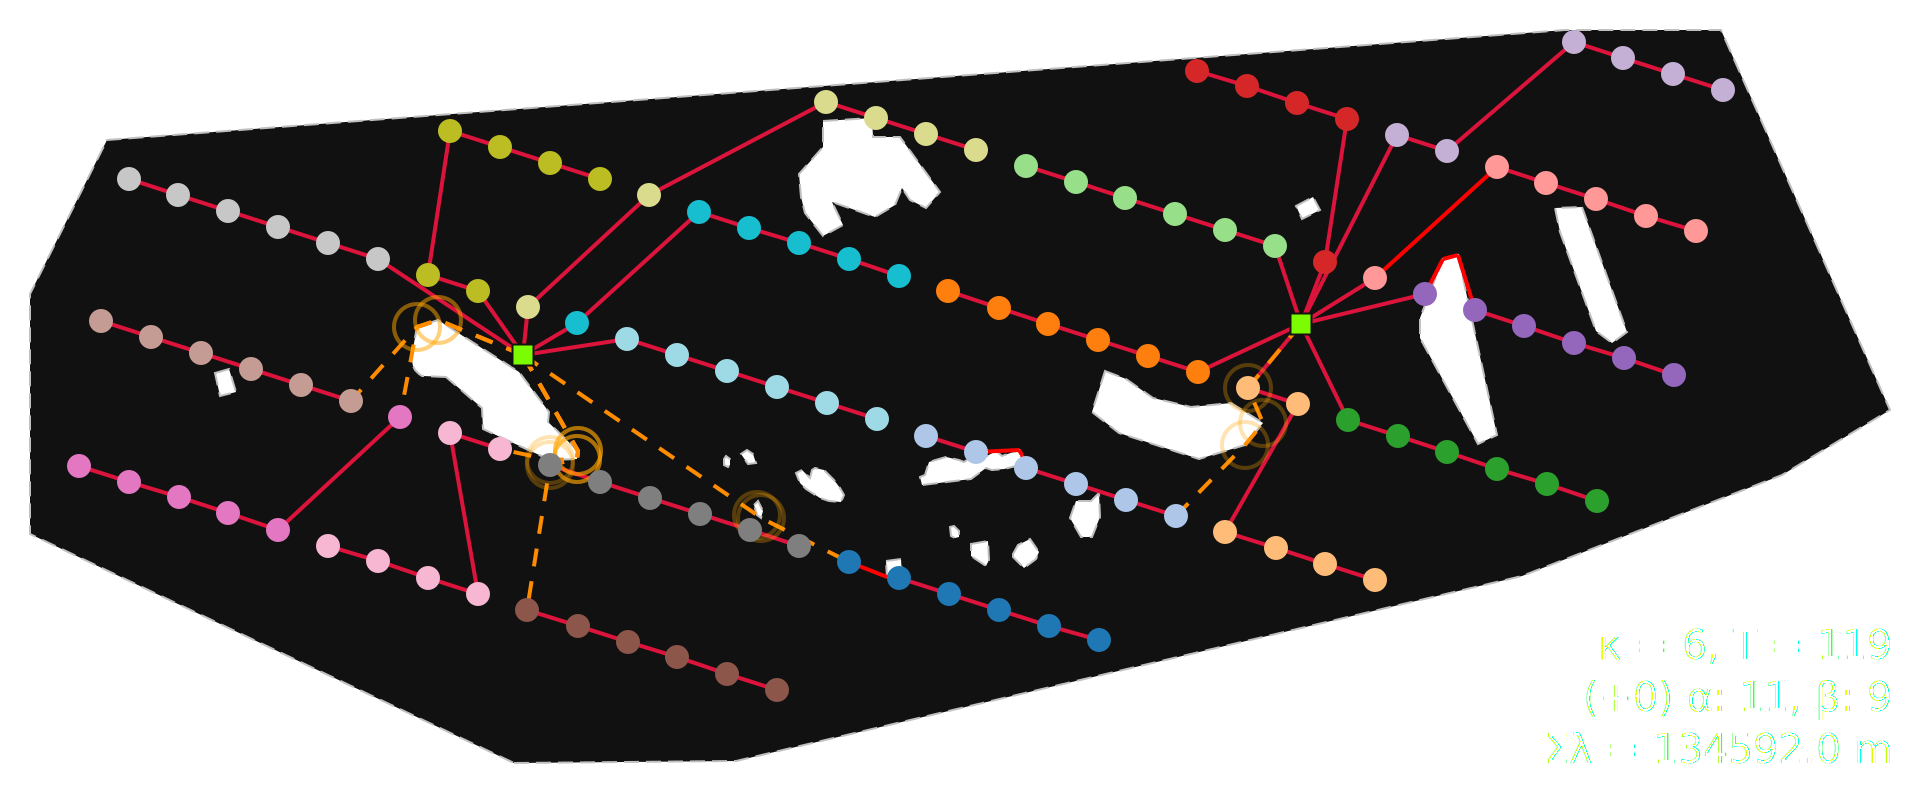

In [30]:
svgplot(G)

In [31]:
1 - G.size(weight='length')/λ_radial

0.17072176123560445

In [32]:
with open('yi_2019_κ_6_radial_our.dill', 'wb') as outfile:
    dill.dump(G, outfile)